## Demonstration of using sacred sequences

This notebook shows how to run a version of [the main demo notebook](/songbird.ipynb) that keeps some sequences - the sacred sequences - fixed.

This can be useful if you want to learn sequences in one setting, then try to find them in another - for example learn some sequences in the awake data then see if you find them in sleep.

In [65]:
# Import PPSeq
import PPSeq
const seq = PPSeq

# Other Imports
import PyPlot: plt
import DelimitedFiles: readdlm
import Random
import StatsBase: quantile

# Songbird metadata
num_neurons = 75
max_time = 22.2

# Randomly permute neuron labels.
# (This hides the sequences, to make things interesting.)
_p = Random.randperm(num_neurons)

# Load spikes.
spikes = seq.Spike[]
for (n, t) in eachrow(readdlm("data/songbird_spikes.txt", '\t', Float64, '\n'))
    push!(spikes, seq.Spike(_p[Int(n)], t))
end

## Plot a spike raster

Some useful visualization functions are provided for you in `src/utils/visualization.jl`

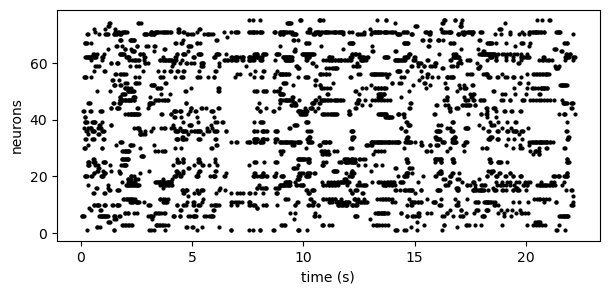

In [51]:
fig = seq.plot_raster(spikes; color="k") # returns matplotlib Figure
fig.set_size_inches([7, 3]);

#### Let's split the spikes into the initial ones to train the sequences, then some extra ones to go hunting in!

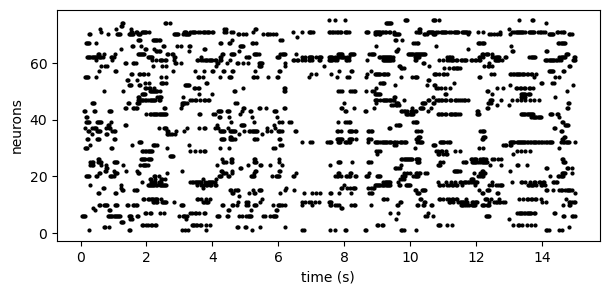

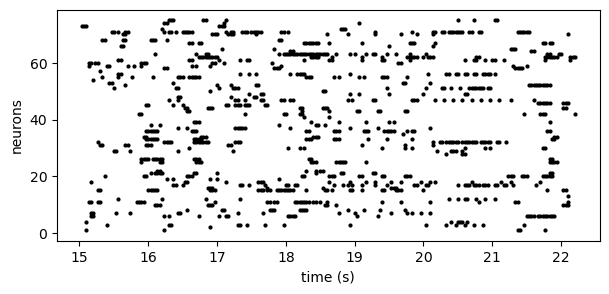

In [52]:
time_cutoff = 15

spikes_train = seq.Spike[]
spikes_test = seq.Spike[]

for spike in spikes
    if spike.timestamp> 15
        push!(spikes_test, spike)
    else
        push!(spikes_train, spike)
    end
end

fig = seq.plot_raster(spikes_train; color="k") # returns matplotlib Figure
fig.set_size_inches([7, 3]);

fig = seq.plot_raster(spikes_test; color="k") # returns matplotlib Figure
fig.set_size_inches([7, 3]);

## Specify PP-Seq model

There are a lot of hyperparameters associated with the pp-Seq model and the MCMC inference procedure. To make things as simple as possible, we create a "config dict" which specifies them all in one place. The table below summarizes the model hyperparameters.

| hyperparameter                | symbol         | Notes |
|:------------------------------|:--------------:|:---------------------|
| num_sequence_types            | $R$            | Number of unique sequence patterns
| seq_type_conc_param           | $\gamma$       | Specifies Dirichlet prior on sequence type probabilities
| seq_event_rate                | $\psi$         | Specifies homogeneous Poisson process for latent events
| mean_event_amplitude          |  N/A           | Specifies $\alpha$ and $\beta$ (supp. eq. #) along with var_event_amplitude
| var_event_amplitude           |  N/A           | Specifies $\alpha$ and $\beta$ (supp. eq. #) along with mean_event_amplitude
| neuron_response_conc_param    | $\varphi$      | Specifies Dirichlet prior on evoked response amplitudes in neural firing rate amplitudes
| neuron_offset_pseudo_obs      | $\kappa$       | Psuedo-observations on mean, Normal-Inverse-Chi-Squared prior
| neuron_width_pseudo_obs       | $\nu$          | Psuedo-observations on variance, Normal-Inverse-Chi-Squared prior 
| neuron_width_prior            | $\sigma^2$     | Variance parameter on Normal-Inverse-Chi-Squared prior
| mean_bkgd_spike_rate          | N/A            | Specifies the mean of Gamma prior on $\lambda_\varnothing$ (specifies $\alpha_\varnothing$ and $\beta_\varnothing$ along with var_bkgd_spike_rate)
| var_bkgd_spike_rate          | N/A            | Specifies the variance of Gamma prior on $\lambda_\varnothing$ (specifies $\alpha_\varnothing$ and $\beta_\varnothing$ along with mean_bkgd_spike_rate)
| bkgd_spikes_conc_param      | $\gamma_\varnothing$ | Specifies Dirichlet prior on relative background firing rates (supp. eq. #)
| mask_lengths                | N/A               | Duration of masked sections
| percent_masked              | N/A               | How much data to hodl out in total
| num_spikes_resamples_per_anneal| N/A            | Number of masked spike resamplings per anneal
| num_spikes_resamples        | N/A               | Number of masked spike resamplings after annealing
| samples_pre_resample        | N/A               | Number of unmasked spike samples per masked resample

In [53]:
config = Dict(

    # Model hyperparameters
    :num_sequence_types =>  2,
    :seq_type_conc_param => 1.0,
    :seq_event_rate => 1.0,

    :mean_event_amplitude => 100.0,
    :var_event_amplitude => 1000.0,
    
    :neuron_response_conc_param => 0.1,
    :neuron_offset_pseudo_obs => 1.0,
    :neuron_width_pseudo_obs => 1.0,
    :neuron_width_prior => 0.5,
    
    :num_warp_values => 1,
    :max_warp => 1.0,
    :warp_variance => 1.0,
    :warp_type => 1,

    :mean_bkgd_spike_rate => 30.0,
    :var_bkgd_spike_rate => 30.0,
    :bkgd_spikes_conc_param => 0.3,
    :max_sequence_length => Inf,
    
    # MCMC Sampling parameters.
    :num_anneals => 10,
    :samples_per_anneal => 100,
    :max_temperature => 40.0,
    :save_every_during_anneal => 10,
    :samples_after_anneal => 2000,
    :save_every_after_anneal => 10,
    :split_merge_moves_during_anneal => 10,
    :split_merge_moves_after_anneal => 10,
    :split_merge_window => 1.0,
    
    # Masking specific parameters
    :are_we_masking => 0, # Binary var, 1 = masking
    :mask_lengths => 2,
    :percent_masked => 10,
    :num_spike_resamples_per_anneal => 20,
    :num_spike_resamples => 200,
    :samples_per_resample => 10,
    
    # For training on some data and resampling on another set
    :sacred_sequences => 0
);

## Train PPSeq model

The `easy_sample!(...)` function is defined in `src/algorithms/easy_sample.jl`. It uses an annealing procedure during the initial MCMC burn-in. See our paper for more details on the specifics of MCMC sampling (Williams et al., 2020).

We're going to train it on some portion of the data and see if it can see the same sequences in the rest of the data.

In [54]:
# Initialize all spikes to background process.
init_assignments = fill(-1, length(spikes_train))

# Construct model struct (PPSeq instance).
model = seq.construct_model(config, max_time, num_neurons)

# Run Gibbs sampling with an initial annealing period.
results = seq.easy_sample!(model, spikes_train, init_assignments, config);

(warp_values, warp_log_proportions) = ([1.0], [0.0])
TEMP:  39.99999999999999
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  26.549315324802276
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  17.621653605394528
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  11.696070952851464
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  7.763066894712855
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  5.152602771881631
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  3.419951893353394
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  2.269934530307346
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.5066301902946675
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.0
10-20-30-40-50-60-70-80-90-100-Done
10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-520-530-540-550-560-570-580-590-600-610-620-630-640-650-660-670-680-690-700-710-720-730-740-750-760-770-780-790-800-810-820-830-840-850-860-870-880-890-

## Plot results

#### Plot raster plot with labeled sequences

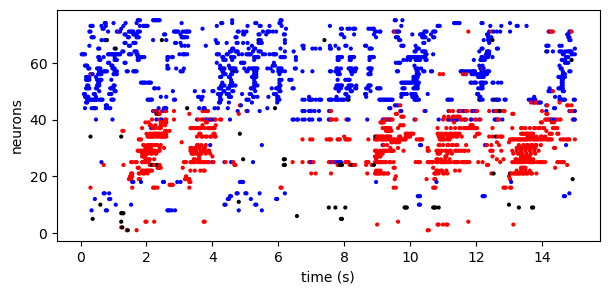

In [55]:
# Grab the final MCMC sample
final_globals = results[:globals_hist][end]
final_events = results[:latent_event_hist][end]
final_assignments = results[:assignment_hist][:, end]

# Helpful utility function that sorts the neurons to reveal sequences.
neuron_ordering = seq.sortperm_neurons(final_globals)

# Plot model-annotated raster.
fig = seq.plot_raster(
    spikes_train,
    final_events,
    final_assignments,
    neuron_ordering;
    color_cycle=["red", "blue"] # colors for each sequence type can be modified.
)
fig.set_size_inches([7, 3]);

#### Plot log-likelihood over MCMC samples

The log-likelihoods during the annealing period are stored in `results[:anneal_log_p_hist]`.

The log-likelihoods during the post-anneal period are stored in `results[:log_p_hist]`.

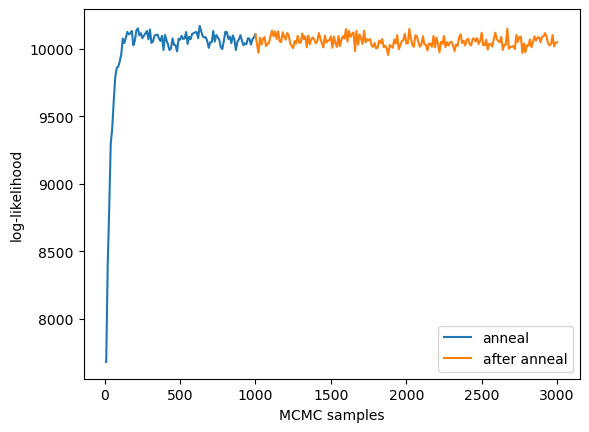

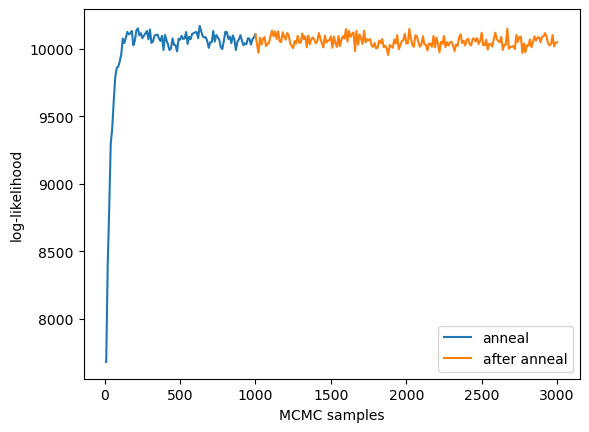

In [56]:
seq.plot_log_likes(config, results)

# Now let's extract the sequence parameters we will fix

In [57]:
# Extract the parameters from the last iteration:
neuron_responses = last(results[:globals_hist]).neuron_response_log_proportions
neurons_offsets = last(results[:globals_hist]).neuron_response_offsets
neurons_widths = last(results[:globals_hist]).neuron_response_widths

# And update the config to say that there are two sacred sequences now, and we want three sequences in total, 2 old, 1 new
config[:sacred_sequences] = 2
config[:num_sequence_types] = 3

sacred_neuron_responses = hcat(neuron_responses, neurons_offsets, neurons_widths)

model_sacred = seq.sanctify_model(model, sacred_neuron_responses, config)

Size of offsets = (75, 2)Offset[1,1] before: -9.027870011938006     Offset[1,-1] before: -3.8914087963145807Offset[1,1] after: -9.027870011938006     Offset[1,-1] after: -3.8914087963145807

PPSeq.SeqModel(22.2, Inf, PPSeq.SeqPriors(1.0, PPSeq.SymmetricDirichlet(conc=1.0, dim=2, log_normalizer=0.0), PPSeq.RateGamma(10.000000000000002, 0.10000000000000002), PPSeq.SymmetricDirichlet(conc=0.1, dim=75, log_normalizer=161.4190846433067), PPSeq.NormalInvChisq(1.0, 0.0, 1.0, 0.5), PPSeq.RateGamma(30.0, 1.0), PPSeq.SymmetricDirichlet(conc=0.3, dim=75, log_normalizer=35.2648708155469), [1.0], [0.0]), PPSeq.SeqGlobals([-1.0189747139336625, -0.44779580692623683], [-9.027870011938006 -3.8914087963145807; -9.00578196724872 -5.6204688564016285; … ; -4.597148047506151 -38.357886254783125; -15.671528629874537 -7.607662948363228], [-0.10175939469204842 0.0008348969823532282; -5.654154042085328 0.2035978462997716; … ; 0.252858516547625 0.7867125268855995; 0.5523070018021398 -0.252633657274617], [12.088435577749802 0.1453567089826043; 152.0135445603321 0.05460331642273835; … ; 0.2206413346060176 0.4895998462444212; 1.8103577410516223 0.6597284675535557], 3.970823407815649, [-8.08207419792886

In [58]:
# Now we can run this model on the rest of the data

# Initialize all spikes to background process.
init_assignments = fill(-1, length(spikes_test))

# Run Gibbs sampling with an initial annealing period.
results_test = seq.easy_sample!(model_sacred, spikes_test, init_assignments, config);

TEMP:  39.99999999999999
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  26.549315324802276
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  17.621653605394528
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  11.696070952851464
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  7.763066894712855
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  5.152602771881631
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  3.419951893353394
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  2.269934530307346
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.5066301902946675
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.0
10-20-30-40-50-60-70-80-90-100-Done
10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-520-530-540-550-560-570-580-590-600-610-620-630-640-650-660-670-680-690-700-710-720-730-740-750-760-770-780-790-800-810-820-830-840-850-860-870-880-890-900-910-920-930-940-950-960-970-980-990-1000-1010-102

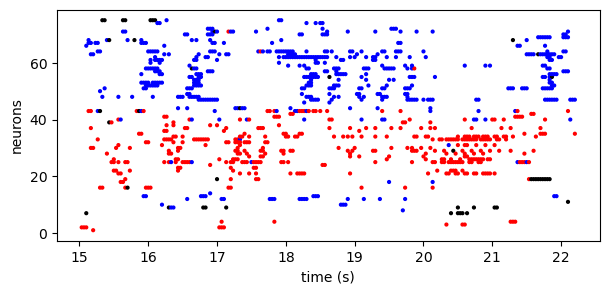

In [63]:
# Grab the final MCMC sample
final_globals = results_test[:globals_hist][end]
final_events = results_test[:latent_event_hist][end]
final_assignments = results_test[:assignment_hist][:, end]

# Helpful utility function that sorts the neurons to reveal sequences.
neuron_ordering = seq.sortperm_neurons(final_globals)

# Plot model-annotated raster.
fig = seq.plot_raster(
    spikes_test,
    final_events,
    final_assignments,
    neuron_ordering;
    color_cycle=["red", "blue", "green"] # colors for each sequence type can be modified.
)
fig.set_size_inches([7, 3]);

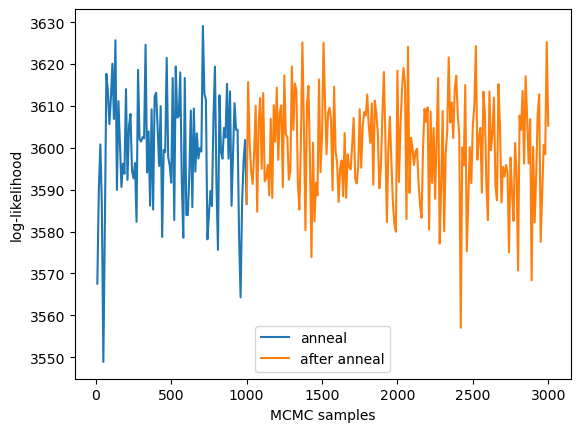

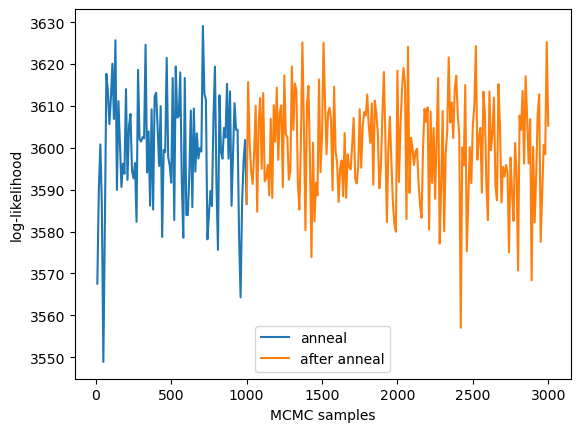

In [64]:
seq.plot_log_likes(config, results_test)